In [1]:
# imports
import numpy as np
import pandas as pd
from scipy.stats import chi2, chi2_contingency

In [2]:
import geopandas

In [3]:
# read raw data
raw = pd.read_parquet("shoppingcarts.parquet", engine ='pyarrow')

In [4]:
# compute sales per county and product for later use
sales_per_county = raw.groupby("county")["product_id"].count().rename("Bestellungen pro County")
sales_per_product = raw.groupby("product_id")["order_id"].count().rename("Bestellungen pro Produkt")

## Frage 1
###  Prüfen Sie, ob es belastbare Unterschiede im Wiederbestellverhalten zwischen den Produkten mit den product_ids 6217, 14778 und 23579 gibt. 

In [4]:
# filter to 6217, 14778 & 23579
# count reorders, compute fraction of reorders and avg time until reorder
# rename columns
df_q1 = raw[raw.product_id.isin([6217, 14778, 23579])].groupby("product_id")\
        .agg({"product_name": pd.Series.mode, "order_id": "count", "reordered": "mean", "days_since_prior_order": "mean"})\
        .rename(columns={"product_name": "Bezeichnung", "order_id": "Anzahl Bestellungen", "reordered": "Anteil Wiederbestellungen", "days_since_prior_order": "durchschn. Zeit bis Wiederbestellung"})

In [5]:
q1_1 = raw[raw.product_id.isin([6217, 14778, 23579])]
total = chi2_contingency(pd.crosstab(q1_1['product_id'],q1_1['reordered'], margins = False, normalize = False), correction=False)

q1_2 = q1_1[q1_1["product_id"] != 23579]
no23579 = chi2_contingency(pd.crosstab(q1_2['product_id'],q1_2['reordered'], margins = False, normalize = False), correction=False)

q1_3 = q1_1[q1_1["product_id"] != 14778]
no14778 = chi2_contingency(pd.crosstab(q1_3['product_id'],q1_3['reordered'], margins = False, normalize = False), correction=False)

q1_4 = q1_1[q1_1["product_id"] != 6217]
no6217 = chi2_contingency(pd.crosstab(q1_4['product_id'],q1_4['reordered'], margins = False, normalize = False), correction=False)

df_stats = pd.DataFrame([
    ["...allen 3 Produkten", *total],
    ["...6217 & 14778", *no23579],
    ["...6217 & 23579", *no14778],
    ["...14778 & 23579", *no6217]])
df_stats.columns = ["Abhängigkeit zwischen...", "Teststatistik χ²", "p-Wert", "Freiheitsgrade", "Signifikant"]
df_stats["Signifikant"] = df_stats["p-Wert"] < 0.05

Belastbarer Unterschied hieße Abhängigkeit zwischen Reordered und product_id für Kreuztabelle. -> chi2
- Imbalance Product 6217, dieses Produkt anscheinend anderes Kaufverhalten
- Product 14778 & 23579 beinahe identisch nachgefragt... 

Betrachtung von durchschn. Zeit bis Wiederbestellung schwierig, da starke Konfundierung mit restlichen Items im Warenkorb vorliegen müsste

In [6]:
df_stats

,Abhängigkeit zwischen...,Teststatistik χ²,p-Wert,Freiheitsgrade,Signifikant
0,...allen 3 Produkten,5.016401,0.081415,2,False
1,...6217 & 14778,4.967545,0.025827,1,True
2,...6217 & 23579,4.858995,0.027502,1,True
3,...14778 & 23579,0.008456,0.926734,1,False


Ergebnis: Anscheinend sind

In [6]:
df_q1

,Bezeichnung,Anzahl Bestellungen,Anteil Wiederbestellungen,durchschn. Zeit bis Wiederbestellung
product_id,,,,
6217,Pumpkin Spice Protein Bar,46,0.456522,10.133333
14778,Organic Chocolate Chip Chewy Granola Bars,1329,0.619263,11.425059
23579,Peanut Butter Chocolate Chip Fruit & Nut Food Bar,1357,0.617539,11.003965


## Frage 2
### Schwankt die Popularität von Produkt 9390 zwischen den Regionen?

In [238]:
# filter to 9390, group by county and count orders
# sort and rename
df_q2 = raw[raw.product_id == 9390].groupby("county").agg({"order_id": "count"})\
        .sort_values(by="order_id",ascending=False)\
        .rename(columns={"order_id": "Anzahl Bestellungen"})
# compute fraction of orders
df_q2["Anteil Bestellungen"] = df_q2["Anzahl Bestellungen"] / int(df_q2.sum())
# compute share of product per county
df_q2["Anteil Bestellungen in County"] = df_q2["Anzahl Bestellungen"] / sales_per_county

In [239]:
df_q2["Anzahl Bestellungen"].sum()

929

Schwankungen im Anteil County um Faktor 10
(von 0.05 - 0.005 % der Gesamtbestellungen)
Schwankungen im Anteil des Produktes um Faktor 10
(von 1% - 0.1%)

In [240]:
df_q2 = df_q2.sort_values(by='Anteil Bestellungen', ascending = True).reset_index()

In [244]:
!pip install plotly

In [245]:
import plotly.express as px

In [246]:
import plotly.express as px
import plotly.graph_objs as go
#fig = px.bar (df_q2, x='county',y = 'Anzahl Bestellungen',title='Bestellung Produkt 9390 nach Counties')
#fig.show()
bins = [0,50,100]
labels = ['Rest', 'Top 5']
colors = {'Rest':'gray','Top 5':'red'}
df_q2['label'] = pd.cut(df_q2['Anzahl Bestellungen'], bins=bins, labels=labels)
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county,
                       y=label_df['Anzahl Bestellungen'],
                       name=label,
                       marker={'color':colors[label]}))


my_layout = ({"title": "Bestellung Produkt 9390 nach Counties",
              "yaxis": {"title":"Anzahl Bestellungen"},
              "xaxis": {"title":"Counties"},
              "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})

ImportError: Please install ipywidgets>=7.0.0 to use the FigureWidget class

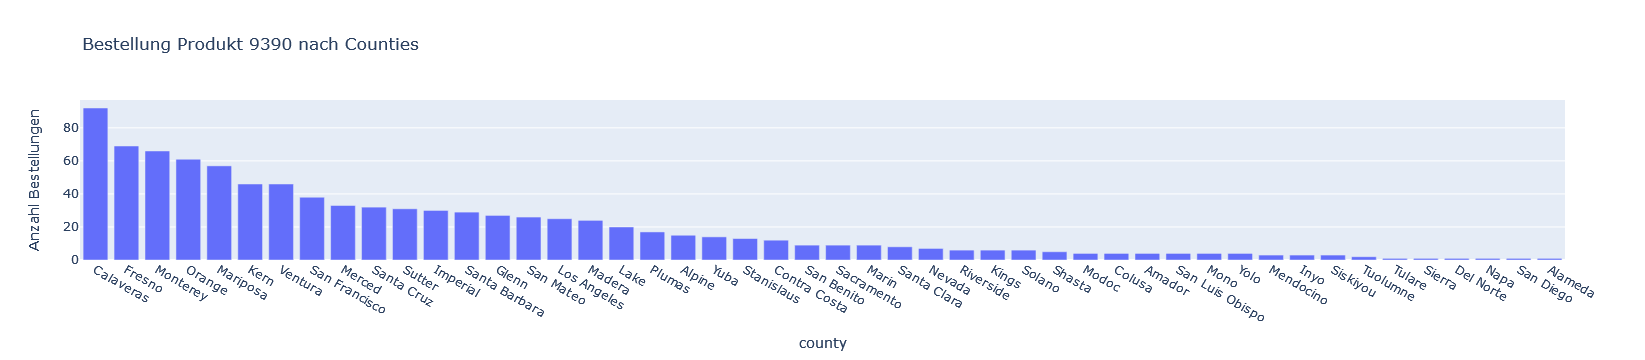

In [26]:
fig = px.bar (df_q2, x='county',y = 'Anzahl Bestellungen',title='Bestellung Produkt 9390 nach Counties')
fig.show()

In [29]:
df_q2 = df_q2.sort_values(by='Anteil Bestellungen in County', ascending = True)

In [31]:
df_q2

,level_0,index,county,Anzahl Bestellungen,Anteil Bestellungen,Anteil Bestellungen in County,label
0,3,46,San Diego,1,0.001076,0.000038,Rest
1,2,43,Sierra,1,0.001076,0.000038,Rest
2,7,40,Siskiyou,3,0.003229,0.000038,Rest
3,11,34,Amador,4,0.004306,0.000039,Rest
4,10,32,Modoc,4,0.004306,0.000048,Rest
5,14,37,Yolo,4,0.004306,0.000052,Rest
6,8,39,Inyo,3,0.003229,0.000054,Rest
7,1,42,Tulare,1,0.001076,0.000056,Rest
8,5,44,Del Norte,1,0.001076,0.000057,Rest
9,4,45,Napa,1,0.001076,0.000059,Rest


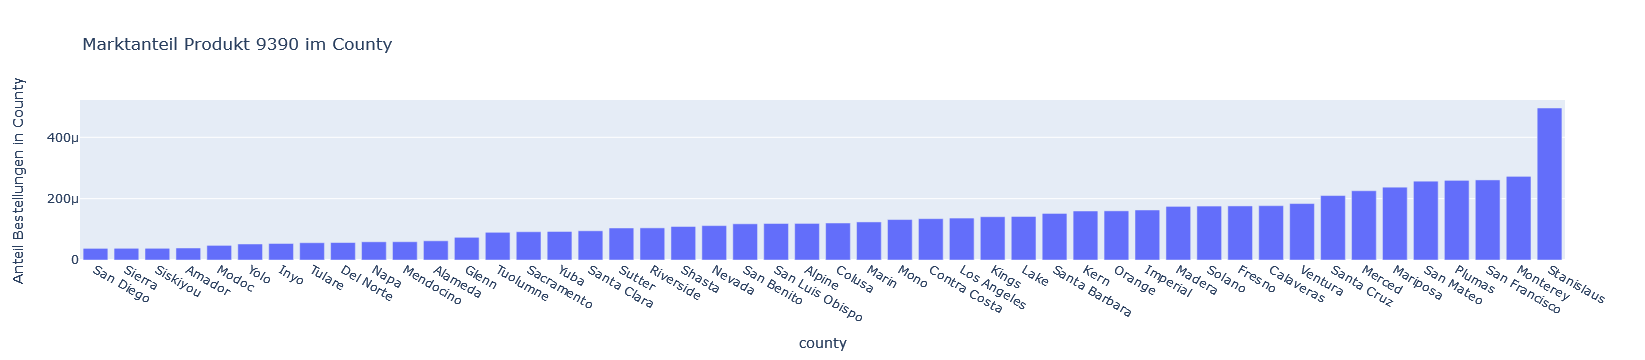

In [33]:
fig = px.bar (df_q2, x='county',y = 'Anteil Bestellungen in County',title='Marktanteil Produkt 9390 im County')
fig.show()

In [ ]:
df_q2 = df_q2.sort_values(by='Anteil Bestellungen in County', ascending = True)
bins = [0,0.00024,1]
labels = ['Rest', 'Top 5']
colors = {'Rest':'gray','Top 5':'red'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen in County'], bins=bins, labels=labels)
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county,
                       y=label_df['Anteil Bestellungen in County'],
                       name=label,
                       marker={'color':colors[label]}))
my_layout = ({"title": "Marktanteil Produkt 9390 im County",
                       "yaxis": {"title":"Marktanteil Produkt in County"},
                       "xaxis": {"title":"Counties"},
                       "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})

Kombidarstellung

In [ ]:
bins = [0,0.0151,1]
labels = ['Rest', 'Top 20 Produktnachfrage']
colors = {'Rest':'gray','Top 20 Produktnachfrage':'red'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen'], bins=bins, labels=labels)
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county,
                       y=label_df['Anteil Bestellungen in County'],
                       name=label,
                       marker={'color':colors[label]}))
my_layout = ({"title": "Marktanteil Produkt 9390 im County + Counties mit hohem Produktanteil",
              "yaxis": {"title":"Marktanteil Produkt in County"},
              "xaxis": {"title":"Counties"},
              "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})

In [ ]:
bins = [0,0.000136,1]
labels = ['Rest', 'Top 20 Nachfragecounties']
colors = {'Rest':'gray','Top 20 Nachfragecounties':'red'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen in County'], bins=bins, labels=labels)
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county,
                       y=label_df['Anzahl Bestellungen'],
                       name=label,
                       marker={'color':colors[label]}))
my_layout = ({"title": "Marktanteil Produkt 9390 im County + Counties mit hohem Produktanteil",
              "yaxis": {"title":"Anzahl Bestellungen"},
              "xaxis": {"title":"Counties"},
              "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})

## Frage 3
### Sind die Produkte 9390, 2713, 21883 und 16753 in den gleichen Regionen populär und unpopulär, oder unterscheiden sich die Muster?

In [5]:
# filter to 9390, 2713, 21883 & 16753, group by county and product id and count orders
# rename column
df_q3 = raw[raw.product_id.isin([9390, 2713, 21883, 16753])].groupby(["county","product_id"]).agg({"order_id": "count"})\
        .rename(columns={"order_id": "Anzahl Bestellungen"})
# join sales per product
df_q3 = df_q3.merge(sales_per_product, left_index=True, right_index=True)
# compute fraction
df_q3["Anteil Bestellungen"] = df_q3["Anzahl Bestellungen"] / df_q3["Bestellungen pro Produkt"]

Das hier vielleicht über die Maps darstellen? Pro Produkt eine Map erstellen

In [6]:
df_q3 = df_q3.sort_values(by=["product_id","Anteil Bestellungen"],ascending=False).reset_index()

In [7]:
from urllib.request import urlopen
#import geojson

with urlopen('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson') as response:
    california_geojson = geopandas.read_file(response)

County Bezeichnungen stimmen is Geodaten und raw überein!

In [8]:
np.sort(raw.county.unique()) == np.sort(california_geojson.name.unique())

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [9]:
q3 = np.sort(df_q3.county.unique())
geo = np.sort(california_geojson.name.unique())

match = []
unique = []

for el in geo:
    if el in q3:
        match.append(el)
    else:
        unique.append(el)
print(match)
print(unique)
# Drop unique States in GeoDF, die nicht in q3 relevant sind

['Alameda', 'Alpine', 'Amador', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Diego', 'San Francisco', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']
['Butte', 'El Dorado', 'Placer', 'San Bernardino', 'San Joaquin', 'Trinity']


In [10]:
geopd = california_geojson[['name','geometry']]

In [11]:
df_q3g = pd.merge(geopd,df_q3,how='outer',left_on='name',right_on='county').drop('county',axis=1).rename(columns={'geometry':'Koordinaten', 'name':'county'})
df_q3g = geopandas.GeoDataFrame(df_q3g,geometry='Koordinaten')

In [14]:
def pipe(df,ids):
    df = df[df.product_id==ids]
    fil = np.sort(df.county.unique())
    geo = np.sort(california_geojson.name.unique())
    match = []
    unique = []

    for el in geo:
        if el in fil:
            match.append(el)
        else:
            unique.append(el)
    for el in unique:
        new_row = {'county':el, 'Koordinaten':california_geojson[california_geojson.name==el]['geometry'].values[0], 'product_id':0, 'Anzahl Bestellungen':0,'Bestellungen pro Produkt':0,'Anteil Bestellungen':0}
        df = df.append(new_row, ignore_index=True)
        df.Koordinaten = df.Koordinaten.astype('geometry')
    return df

In [16]:
import matplotlib.pyplot as plt

C:\Users\torbe\anaconda3\envs\DA\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\torbe\anaconda3\envs\DA\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\torbe\anaconda3\envs\DA\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\torbe\anaconda3\envs\DA\lib\site-p

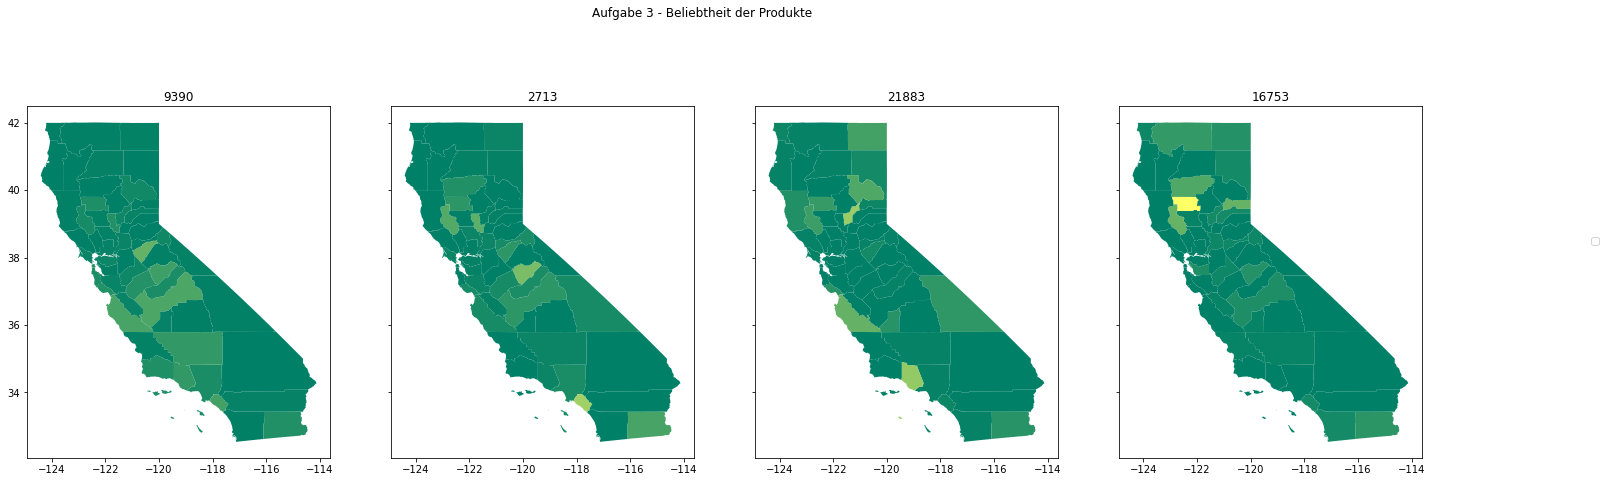

In [17]:
cmap = 'summer'
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, sharex=True, sharey=True)
fig.suptitle('Aufgabe 3 - Beliebtheit der Produkte')
pipe(df_q3g, 9390).plot(ax = ax1,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 2713).plot(ax =ax2,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 21883).plot(ax =ax3,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 16753).plot(ax =ax4,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
ax1.set_title('9390')
ax2.set_title('2713')
ax3.set_title('21883')
ax4.set_title('16753')
fig.set_size_inches(25, 8)
handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

Effizienter als Erzeugen über Plotly: Legende aus unterern tabelle croppen und Einfügen

In [19]:
df_9390=pipe(df_q3g, 9390)
df_2713=pipe(df_q3g, 2713)
df_21883=pipe(df_q3g, 21883)
df_16753=pipe(df_q3g, 16753)

C:\Users\torbe\anaconda3\envs\DA\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\torbe\anaconda3\envs\DA\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\torbe\anaconda3\envs\DA\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\torbe\anaconda3\envs\DA\lib\site-p

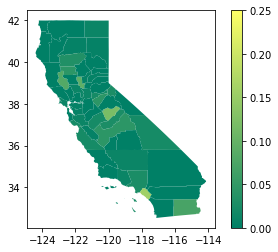

In [20]:
#df_9390.plot(column='Anteil Bestellungen',legend=True,cmap='hot')
df_2713.plot(column='Anteil Bestellungen',legend=True,cmap='summer',vmin=0,vmax=0.25)
fig.set_size_inches(25, 8)

In [23]:
import plotly.graph_objects as go

In [ ]:
df_9390_t5 = df_9390.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_2713_t5= df_2713.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_21883_t5 = df_21883.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_16753_t5 = df_16753.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)

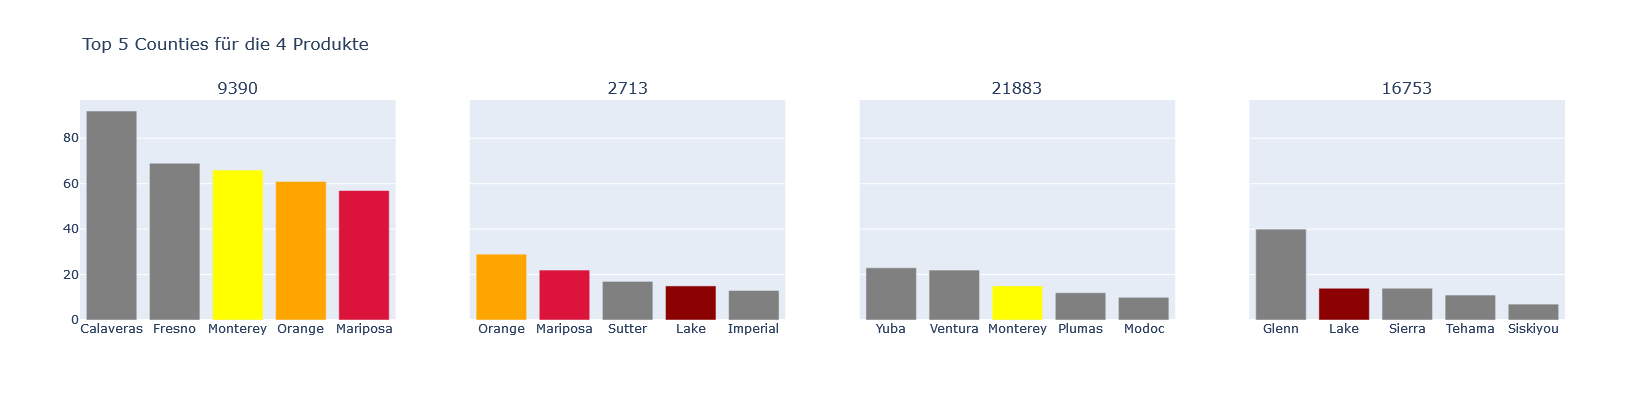

In [64]:
from plotly.subplots import make_subplots
colors1=['grey']*5
colors2=['grey']*5
colors3=['grey']*5
colors4=['grey']*5
colors1[2]='yellow'
colors1[3]='orange'
colors1[4]='crimson'
colors2[0]='orange'
colors2[1]='crimson'
colors2[3]='darkred'
colors3[2]='yellow'
colors4[1]='darkred'
fig = make_subplots(rows=1,
                    cols=4,
                    shared_yaxes='all',
                    subplot_titles = ['9390','2713','21883','16753'])

fig.add_trace(
    go.Bar(x=df_9390_t5.county, y=df_9390_t5['Anzahl Bestellungen'], name = '9390',marker_color=colors1),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df_2713_t5.county, y=df_2713_t5['Anzahl Bestellungen'], name = '2713',marker_color=colors2),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df_21883_t5.county, y=df_21883_t5['Anzahl Bestellungen'], name = '21883',marker_color=colors3),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df_16753_t5.county, y=df_16753_t5['Anzahl Bestellungen'], name = '16753',marker_color=colors4),
    row=1, col=4
)
fig.update_layout(height=400, width=1200,
                  title_text="Top 5 Counties für die 4 Produkte",
                  #colorway= ['green','green','green','green'],
                  showlegend=False)

fig.show()

In [50]:
simil = df_9390_t5.county.tolist() + df_2713_t5.county.tolist() + df_21883_t5.county.tolist() + df_16753_t5.county.tolist()
simil.sort()

In [51]:
simil

['Calaveras',
 'Fresno',
 'Glenn',
 'Imperial',
 'Lake',
 'Lake',
 'Mariposa',
 'Mariposa',
 'Modoc',
 'Monterey',
 'Monterey',
 'Orange',
 'Orange',
 'Plumas',
 'Sierra',
 'Siskiyou',
 'Sutter',
 'Tehama',
 'Ventura',
 'Yuba']

## Frage 4
### Welche Counties sind sich ähnlich in Hinblick auf den Produktmix?

In [277]:
# group by county and department and count orders
# pivot to reshape from long to wide
df_q4 = raw.groupby(["county", "department"], as_index=False)[["order_id"]].count()\
        .pivot(index="county", columns="department", values="order_id")

In [278]:
# Drop Counties with low product numbers, missing information doesnt allow to deduce product mix
# Drop: Count Products < 1000: Trinity, San Bernardino, Placer, Butte
df_q4.drop(['Trinity','San Bernardino','Placer','Butte'],axis=0,inplace=True)

In [279]:
# Compute Share of Categories in County
df_q4 = df_q4.fillna(0)
df_q4['sum'] = df_q4.sum(axis=1)
for el in df_q4.columns:
    df_q4[f'{el}_r'] = df_q4[el]/df_q4['sum']
df_q4_1 = df_q4.loc[:,'alcohol_r':'snacks_r']

In [178]:
pd.options.display.max_columns = 999
#deduce cut off values for segmentation in high, medium low demand -> low -> 0.1 quartile, medium -> 0.1-0.9 quartile, high -> 0.9 quartile
# Apply this segmentation for each product allows for a comparison with other Counties
df_q4_1.describe()

department,alcohol_r,babies_r,bakery_r,beverages_r,breakfast_r,bulk_r,canned goods_r,dairy eggs_r,deli_r,dry goods pasta_r,frozen_r,household_r,international_r,meat seafood_r,missing_r,other_r,pantry_r,personal care_r,pets_r,produce_r,snacks_r
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.008041,0.010726,0.036291,0.087820,0.022754,0.001317,0.031872,0.167188,0.031355,0.025966,0.068234,0.026780,0.008284,0.020962,0.002216,0.001499,0.056790,0.015449,0.003941,0.282171,0.090344
std,0.010724,0.004744,0.007067,0.028610,0.005188,0.002019,0.009168,0.015754,0.008129,0.007235,0.011975,0.011282,0.002240,0.004833,0.001070,0.001359,0.011290,0.004888,0.003359,0.054496,0.024940
min,0.000000,0.000000,0.020503,0.014066,0.010474,0.000038,0.009133,0.128213,0.013156,0.007473,0.026531,0.009031,0.003190,0.009576,0.000097,0.000282,0.021545,0.005124,0.000534,0.156736,0.035460
25%,0.001256,0.007384,0.031276,0.075437,0.019369,0.000394,0.025505,0.156700,0.027223,0.021013,0.062838,0.017990,0.006952,0.018500,0.001630,0.000668,0.053384,0.012394,0.001594,0.256172,0.084249
50%,0.002772,0.010185,0.036170,0.086620,0.022887,0.000783,0.034565,0.167214,0.033335,0.027656,0.070811,0.026478,0.008616,0.022134,0.001996,0.000930,0.059152,0.014741,0.003062,0.285884,0.090319
75%,0.011772,0.014526,0.041055,0.100510,0.026504,0.001085,0.037388,0.177485,0.036928,0.031553,0.076342,0.033819,0.009893,0.023956,0.002549,0.001700,0.063158,0.018747,0.005030,0.315918,0.099404
max,0.052292,0.021705,0.053129,0.176296,0.039488,0.011280,0.052057,0.202817,0.048939,0.039070,0.097742,0.060684,0.012441,0.030636,0.005775,0.006746,0.082591,0.028089,0.015514,0.399310,0.162014


In [280]:
for el in df_q4_1.columns:
    df_q4_1[f'{el}_c'] = pd.cut(df_q4_1[el],[-1,df_q4_1[el].quantile(0.1),df_q4_1[el].quantile(0.9),1],labels=['low','medium','high'])
df_q4_2 = df_q4_1.loc[:,'alcohol_r_c':]

In [290]:
df_cluster = df_q4.loc[:,'alcohol_r':'snacks_r'].fillna(0)

from sklearn.cluster import KMeans

cluster = [3,4,5,15]
X = df_cluster

for el in cluster:
    kmeans = KMeans(n_clusters=el, random_state=0).fit(X)
    df_cluster[f"{el}-Cluster Lösung"] = kmeans.labels_

In [346]:
# get cagetory mean
# remove other cluster solutions
# get variance to evaluate cluster-relevance of each category
# sort cluster_relevance
# Calculate sum to compare Models
print(df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)\
                                      .sum())
print(df_cluster.groupby('4-Cluster Lösung').mean().drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('15-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','3-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())

0.2308853526942269
0.18686876805207264
0.18376598375349035
0.24517171826674858


Erkenntnis: Cluster 5 differenziert deutlich stärker zwischen den Daten, 3/4 Cluster kaum Unterschied. Analysen auf 5 Cluster fortführen (15 zu unübersichtlich)

In [321]:
df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)

department
produce_r            0.075904
beverages_r          0.035838
snacks_r             0.023042
pantry_r             0.013052
alcohol_r            0.011876
household_r          0.011546
dairy eggs_r         0.008284
bakery_r             0.007777
frozen_r             0.007024
canned goods_r       0.006537
dry goods pasta_r    0.004851
breakfast_r          0.004498
meat seafood_r       0.004387
personal care_r      0.003732
deli_r               0.003426
babies_r             0.002993
pets_r               0.002468
international_r      0.001579
bulk_r               0.001107
other_r              0.000667
missing_r            0.000295
dtype: float64

In [318]:
x1 = df_cluster.groupby('5-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)
x2 = df_cluster.groupby('15-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','5-Cluster Lösung','3-Cluster Lösung'],axis=1)

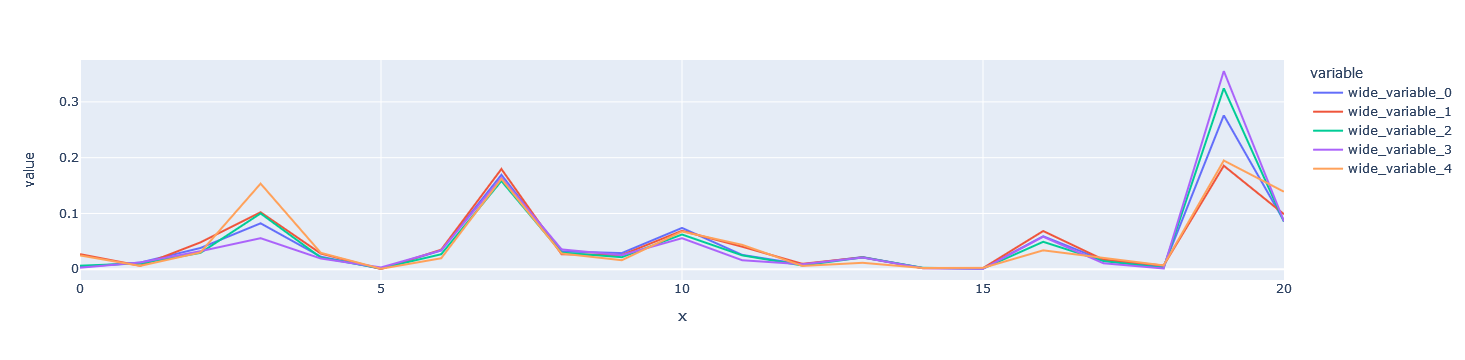

In [ ]:
import plotly.express as px
y = [np.array(x1.iloc[0]),np.array(x1.iloc[1]),np.array(x1.iloc[2]),np.array(x1.iloc[3]),np.array(x1.iloc[4])]
fig = px.line(x=np.arange(x1.shape[1]), y=y)
fig.show()

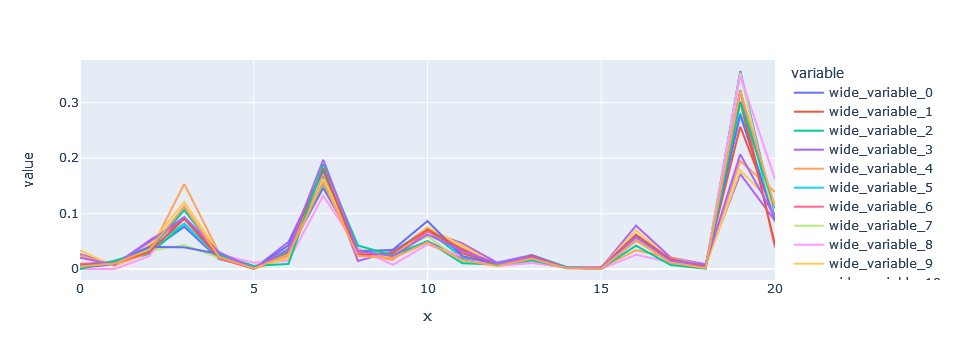

In [328]:
x = x2
y = [np.array(x.iloc[0]),np.array(x.iloc[1]),np.array(x.iloc[2]),np.array(x.iloc[3]),np.array(x.iloc[4]),np.array(x.iloc[5]),np.array(x.iloc[6]),
     np.array(x.iloc[7]),np.array(x.iloc[8]),np.array(x.iloc[9]),np.array(x.iloc[10]),np.array(x.iloc[11]),np.array(x.iloc[12]),np.array(x.iloc[13]),np.array(x.iloc[14])]
fig = px.line(x=np.arange(x.shape[1]), y=y)
fig.show()

In [320]:
x1[['beverages_r','pantry_r','produce_r']].round(4)

department,beverages_r,pantry_r,produce_r
5-Cluster Lösung,,,
0,0.0823,0.0591,0.2760
1,0.1022,0.0685,0.1855
2,0.1001,0.0492,0.3245
3,0.0557,0.0583,0.3554
4,0.1535,0.0339,0.1948


In [340]:
print("Counties der Cluster:")
print(df_cluster[df_cluster['5-Cluster Lösung']==0].index)
print(df_cluster[df_cluster['5-Cluster Lösung']==1].index)
print(df_cluster[df_cluster['5-Cluster Lösung']==2].index)
print(df_cluster[df_cluster['5-Cluster Lösung']==3].index)
print(df_cluster[df_cluster['5-Cluster Lösung']==4].index)

Counties der Cluster:
Index(['Alpine', 'Calaveras', 'Contra Costa', 'Glenn', 'Imperial', 'Kings',
       'Lake', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Merced', 'Mono',
       'Monterey', 'Nevada', 'Orange', 'Riverside', 'San Benito',
       'San Joaquin', 'San Luis Obispo', 'Santa Clara', 'Shasta', 'Solano',
       'Stanislaus', 'Tulare', 'Tuolumne', 'Ventura'],
      dtype='object', name='county')
Index(['Del Norte', 'Lassen', 'Modoc', 'San Diego', 'Sierra', 'Tehama'], dtype='object', name='county')
Index(['Alameda', 'El Dorado', 'Inyo', 'Kern', 'Mendocino', 'Plumas',
       'Santa Cruz', 'Siskiyou', 'Sonoma', 'Sutter'],
      dtype='object', name='county')
Index(['Amador', 'Colusa', 'Fresno', 'Sacramento', 'San Francisco',
       'San Mateo', 'Santa Barbara', 'Yolo'],
      dtype='object', name='county')
Index(['Humboldt', 'Napa', 'Yuba'], dtype='object', name='county')


## Frage 5
### Welche der TOP 50-Produkte sind sich ähnlich in Hinblick auf die regionale Verteilung?

In [354]:
# compute top 50 products
top50 = sales_per_product.sort_values().tail(50).index
# filter to top 50 products, group by product and county and count orders
# pivot to reshape from long to wide
df_q5 = raw[raw["product_id"].isin(top50)].groupby(["product_id", "county"], as_index=False)[["order_id"]].count()\
        .pivot(index="product_id", columns="county", values="order_id")

In [361]:
df_q5_1=df_q5.fillna(0)
df_q5_1['sum'] = df_q5_1.sum(axis=1)
    

In [362]:
# Drop Counties with low product numbers, missing information doesnt allow to deduce product mix
# Drop: Count Products < 1000: Trinity, San Bernardino, Placer
df_q5_1.drop(['Trinity','San Bernardino','Placer'],axis=1,inplace=True)

In [363]:
# Compute Share of Counties in product

for el in df_q5_1.columns:
    df_q5_1[f'{el}_r'] = df_q5_1[el]/df_q5_1['sum']
df_q5_1 = df_q5_1.loc[:,'Alameda_r':'Yuba_r']

In [367]:
cluster = [3,4,5,15]
X = df_q5_1

for el in cluster:
    kmeans = KMeans(n_clusters=el, random_state=0).fit(X)
    df_q5_1[f"{el}-Cluster Lösung"] = kmeans.labels_

In [369]:
# get cagetory mean
# remove other cluster solutions
# get variance to evaluate cluster-relevance of each category
# sort cluster_relevance
# Calculate sum to compare Models
df_cluster = df_q5_1
print(df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)\
                                      .sum())
print(df_cluster.groupby('4-Cluster Lösung').mean().drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('15-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','3-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())

0.21350925789146538
0.17576722813213333
0.17945591920887458
0.24200663068648837


In [370]:
df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)

county
Fresno_r             0.014041
Kern_r               0.013826
Sutter_r             0.013687
Glenn_r              0.012960
San Francisco_r      0.012671
Santa Barbara_r      0.009494
Yuba_r               0.008376
San Mateo_r          0.008081
Calaveras_r          0.007024
Modoc_r              0.006590
Lake_r               0.006100
Ventura_r            0.005836
Madera_r             0.005553
Sacramento_r         0.005427
Orange_r             0.005345
Los Angeles_r        0.005048
Nevada_r             0.004405
San Diego_r          0.003673
Mendocino_r          0.003671
Marin_r              0.003656
Stanislaus_r         0.003344
Monterey_r           0.003194
Amador_r             0.003142
Mariposa_r           0.003128
Santa Cruz_r         0.002984
Santa Clara_r        0.002968
Merced_r             0.002909
Plumas_r             0.002532
Alpine_r             0.002466
Yolo_r               0.002310
Mono_r               0.001993
San Benito_r         0.001820
Lassen_r             0.001749
Sha

In [371]:
x1 = df_cluster.groupby('5-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)
x2 = df_cluster.groupby('15-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','5-Cluster Lösung','3-Cluster Lösung'],axis=1)

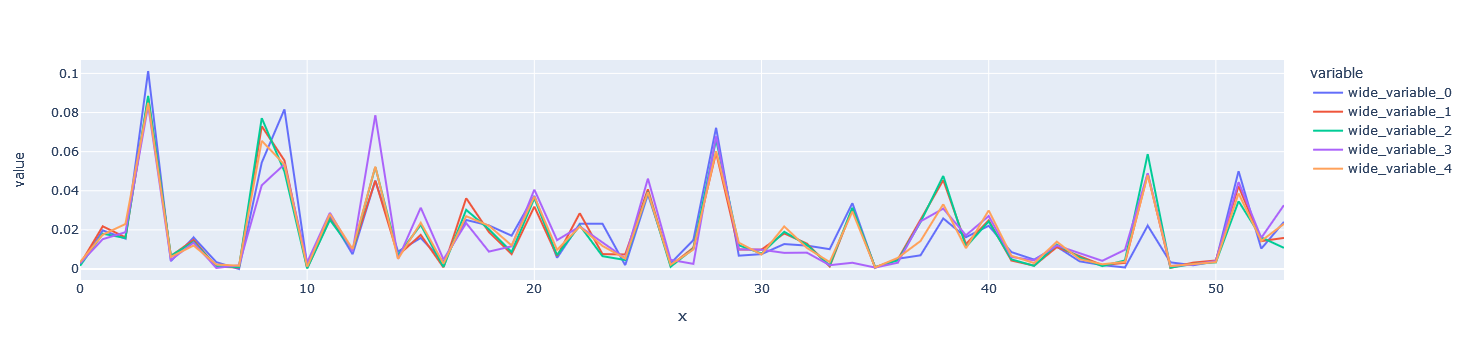

In [372]:
y = [np.array(x1.iloc[0]),np.array(x1.iloc[1]),np.array(x1.iloc[2]),np.array(x1.iloc[3]),np.array(x1.iloc[4])]
fig = px.line(x=np.arange(x1.shape[1]), y=y)
fig.show()

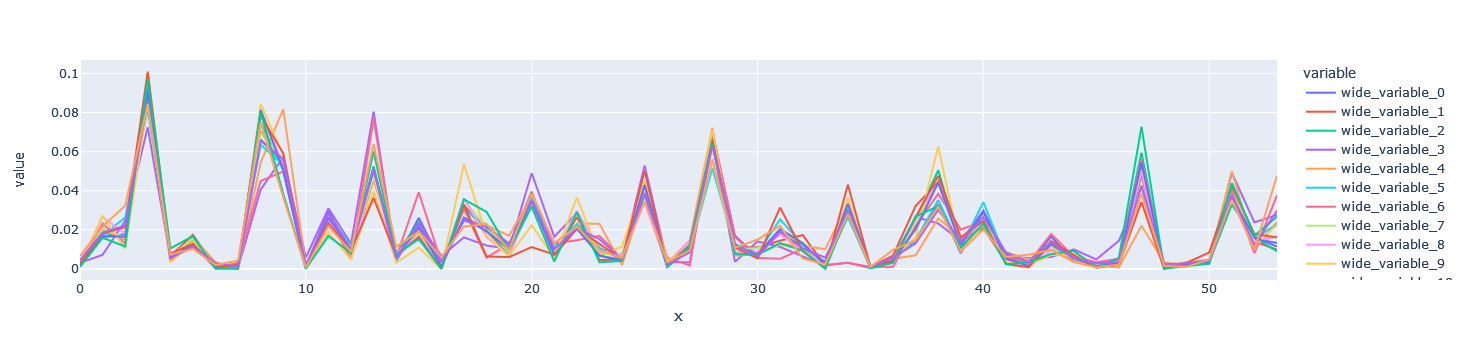

In [373]:
x = x2
y = [np.array(x.iloc[0]),np.array(x.iloc[1]),np.array(x.iloc[2]),np.array(x.iloc[3]),np.array(x.iloc[4]),np.array(x.iloc[5]),np.array(x.iloc[6]),
     np.array(x.iloc[7]),np.array(x.iloc[8]),np.array(x.iloc[9]),np.array(x.iloc[10]),np.array(x.iloc[11]),np.array(x.iloc[12]),np.array(x.iloc[13]),np.array(x.iloc[14])]
fig = px.line(x=np.arange(x.shape[1]), y=y)
fig.show()